In [19]:
"""Imports"""
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.layers import Dense
from keras.models import Sequential
from pathlib import Path
from sklearn.linear_model import LinearRegression


# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

After EDA, it seems that there is little value in keeping anything other than the chemical sensor and date/time data.

In [2]:
"""Load up the raw data, convert data standards, and interpolate"""
path_to_file = Path(Path.cwd().parents[1], "Data", "AirQualityUCI.csv")
raw = pd.read_csv(path_to_file, delimiter=";", decimal=",")
raw_sensor = (
    raw
    .filter(["Date", "Time", "C6H6(GT)", "PT08.S5(O3)"])
).iloc[:9357]

interpolated = raw_sensor.copy()
numeric_cols = interpolated.select_dtypes(include=[np.number]).columns

interpolated[numeric_cols] = (
    interpolated[numeric_cols]
    .replace(-200.0, np.nan)
    .interpolate()
)

interpolated.head()

,Date,Time,C6H6(GT),PT08.S5(O3)
0,10/03/2004,18.00.00,11.90000,1268.00000
1,10/03/2004,19.00.00,9.40000,972.00000
2,10/03/2004,20.00.00,9.00000,1074.00000
3,10/03/2004,21.00.00,9.20000,1203.00000
4,10/03/2004,22.00.00,6.50000,1110.00000


In [3]:
"""Fix Date and time formatting and data type"""
datetime_fixed = interpolated.copy()
datetime_fixed["Time"] = datetime_fixed["Time"].str.replace(".", ":", regex=False)
datetime_fixed["Datetime"] = pd.to_datetime(
    datetime_fixed[["Date", "Time"]]
    .apply(lambda x: 
           " ".join(x.values.astype(str)),
           axis="columns"), 
           dayfirst=True)

datetime_fixed = datetime_fixed.drop("Date", axis=1)
datetime_fixed = datetime_fixed.drop("Time", axis=1)

datetime_fixed.head()

,C6H6(GT),PT08.S5(O3),Datetime
0,11.90000,1268.00000,2004-03-10 18:00:00
1,9.40000,972.00000,2004-03-10 19:00:00
2,9.00000,1074.00000,2004-03-10 20:00:00
3,9.20000,1203.00000,2004-03-10 21:00:00
4,6.50000,1110.00000,2004-03-10 22:00:00


In [ ]:
"""Divide the data and save each new dataset"""
O3 = (
	datetime_fixed
	.filter(["Datetime", "PT08.S5(O3)"])
)
path_to_save = Path(Path.cwd().parents[1], "Data", "Benzene", "O3.csv")
O3.to_csv(path_to_save, index=False)

C6H6 = (
	datetime_fixed
	.filter(["Datetime", "C6H6(GT)"])
)
path_to_save = Path(Path.cwd().parents[1], "Data", "Benzene", "C6H6.csv")
C6H6.to_csv(path_to_save, index=False)

# Time Series Prediction using Linear Regression

In [7]:
"""convert datetime to epoch/unix time and add as new column"""
O3["unix"] = O3["Datetime"].apply(lambda x: x.timestamp())

O3.head()

,Datetime,PT08.S5(O3),unix
0,2004-03-10 18:00:00,1268.00000,1078941600.00000
1,2004-03-10 19:00:00,972.00000,1078945200.00000
2,2004-03-10 20:00:00,1074.00000,1078948800.00000
3,2004-03-10 21:00:00,1203.00000,1078952400.00000
4,2004-03-10 22:00:00,1110.00000,1078956000.00000


In [8]:
"""Setup data and train linear regression model to use as baseline"""
time_series = pd.DataFrame(O3.unix)
sensor_values = pd.DataFrame(O3.filter(["PT08.S5(O3)"]))

number_of_samples = len(time_series)
prediction_horizon = 24 * 3600
mu = 0.9

tp_pred = np.zeros(number_of_samples - 1)
yp_pred = np.zeros(number_of_samples - 1)

for i in range(2, number_of_samples + 1):
    ts_tmp = time_series[0:i]
    ys_tmp = sensor_values[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = weights[k] ** k
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    tp = time_series.iloc[i-1, 0] + prediction_horizon
    yp = m_tmp * tp + q_tmp

    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp.item()

yp_pred = np.where(yp_pred < 0, 0, yp_pred)

In [34]:
"""Extend our timestamps and align predictions"""
start = O3.iloc[-1]["Datetime"] + pd.Timedelta(hours=1)
end = start + pd.Timedelta(hours=23)

extended_timeline = pd.date_range(start=start, end=end, freq="h")

predictions = pd.concat(
    [O3.drop("unix", axis=1),
     pd.DataFrame(
         {"Datetime": extended_timeline, "PT08.S5(O3)": np.nan},
         index=np.arange(9357, 9381))])
predictions["preds"] = np.concatenate([np.full(25, np.nan), yp_pred])

predictions

,Datetime,PT08.S5(O3),preds
0,2004-03-10 18:00:00,1268.00000,NaN
1,2004-03-10 19:00:00,972.00000,NaN
2,2004-03-10 20:00:00,1074.00000,NaN
3,2004-03-10 21:00:00,1203.00000,NaN
4,2004-03-10 22:00:00,1110.00000,NaN
...,...,...,...
9376,2005-04-05 10:00:00,NaN,1992.59085
9377,2005-04-05 11:00:00,NaN,1998.19379
9378,2005-04-05 12:00:00,NaN,1919.33024
9379,2005-04-05 13:00:00,NaN,1708.71746


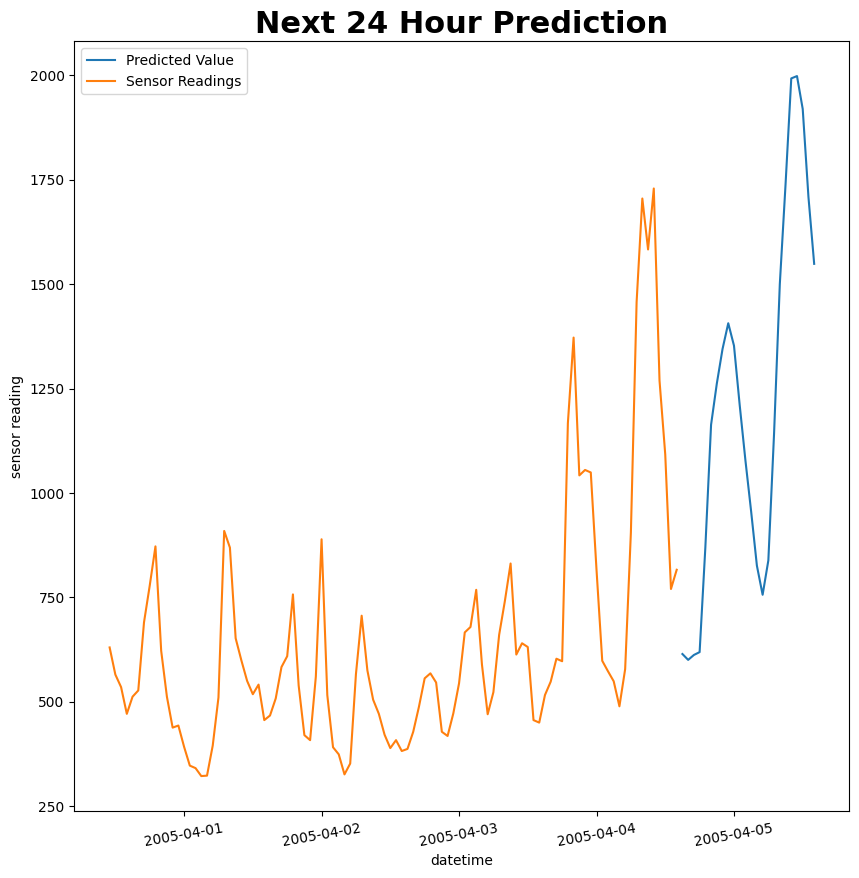

In [36]:
"""Visualize prediction dataframe"""
timestamps = predictions["Datetime"]
sensor = predictions["PT08.S5(O3)"]
preds = predictions["preds"]


fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Next 24 Hour Prediction", fontsize=22, fontweight='bold')
ax.set_ylabel("sensor reading")
ax.set_xlabel("datetime")


ax.plot(timestamps[-24:], preds[-24:], label='Predicted Value')
ax.plot(timestamps[-124:-24],sensor[-124:-24], label='Sensor Readings')
ax.legend()

plt.xticks(rotation=10)
plt.show()

# Anomoly Detection using an Auto Encoder

In [11]:
"""Replace topmost outlier with mean reading"""
C6H6.loc[C6H6["C6H6(GT)"] == C6H6["C6H6(GT)"].max(), "C6H6(GT)"] = C6H6["C6H6(GT)"].mean()
C6H6.describe()

,Datetime,C6H6(GT)
count,9357,9357.00000
mean,2004-09-21 16:00:00,10.17343
min,2004-03-10 18:00:00,0.10000
25%,2004-06-16 05:00:00,4.50000
50%,2004-09-21 16:00:00,8.30000
75%,2004-12-28 03:00:00,14.10000
max,2005-04-04 14:00:00,52.10000
std,NaN,7.48338


In [12]:
"""Min-Max O3 data to match scale of C6H6 data"""
scaled_O3 = O3.copy()
minimum = C6H6["C6H6(GT)"].min()
maximum = C6H6["C6H6(GT)"].max()
scaled_O3["PT08.S5(O3)"] = (scaled_O3["PT08.S5(O3)"] - minimum) / (maximum - minimum)

scaled_O3.head()

,Datetime,PT08.S5(O3),unix
0,2004-03-10 18:00:00,24.38269,1078941600.00000
1,2004-03-10 19:00:00,18.69038,1078945200.00000
2,2004-03-10 20:00:00,20.65192,1078948800.00000
3,2004-03-10 21:00:00,23.13269,1078952400.00000
4,2004-03-10 22:00:00,21.34423,1078956000.00000


In [ ]:
"""Setup training data and testing data"""
training_data = C6H6["C6H6(GT)"]
testing_data = scaled_O3["PT08.S5(O3)"]

min_val = min(training_data)
max_val = max(training_data)

training_data = (training_data - min_val) / (max_val - min_val)
testing_data = (testing_data - min_val) / (max_val - min_val)

training_data = training_data.astype(np.float32)
testing_data = testing_data.astype(np.float32)

seq_length = 7 * 24

sequenced_training = (
    np.array([training_data[i:i + seq_length] for i in range(len(training_data) - seq_length)], dtype=object)
    .astype(np.float32)
)
sequenced_testing = (
    np.array([testing_data[i:i + seq_length] for i in range(len(testing_data) - seq_length)], dtype=object)
    .astype(np.float32)
)

assert(sequenced_training.shape == (len(training_data) - seq_length, seq_length))
assert(sequenced_testing.shape == (len(testing_data) - seq_length, seq_length))

sequenced_training.shape

(9189, 168)

In [14]:
"""Build out and train auto encoder"""
class AnomalyDetector(keras.Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    
    self.encoder = Sequential([
      Dense(42, activation="relu"),
      Dense(21, activation="relu"),
      Dense(8, activation="relu")])

    self.decoder = Sequential([
      Dense(21, activation="relu"),
      Dense(42, activation="relu"),
      Dense(168, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mse')

test_subset = sequenced_training[:50]

history = autoencoder.fit(sequenced_training, sequenced_training,
          epochs=20,
          batch_size=512,
          validation_data=(test_subset, test_subset),
          shuffle=True)



Epoch 1/20


2026-02-07 09:02:29.004495: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1092 - val_loss: 0.0754
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0729 - val_loss: 0.0411
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0367 - val_loss: 0.0456
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0296 - val_loss: 0.0325
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0281 - val_loss: 0.0359
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0277 - val_loss: 0.0337
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273 - val_loss: 0.0332
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0269 - val_loss: 0.0330
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0264 - val_loss: 0.0323
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0256 - val_loss: 0.0316
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246 - val_loss: 0.0306
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 - val_loss: 0.0286


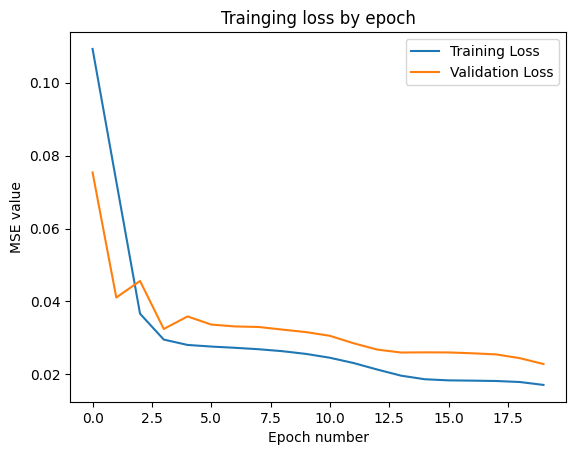

In [15]:
"""Visualize training loss"""
plt.title("Trainging loss by epoch")
plt.ylabel("MSE value")
plt.xlabel("Epoch number")
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [16]:
"""Calculate threshold"""
reconstructions = autoencoder.predict(sequenced_training)
training_loss = keras.losses.mean_squared_error(reconstructions, sequenced_training)

upper_threshold = np.mean(training_loss) + 3 * np.std(training_loss)
lower_threshold = np.mean(training_loss) - 3 * np.std(training_loss)
print(f"Non-anomolous range: {lower_threshold:.4f}-{upper_threshold:.4f}")

288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Non-anomolous range: -0.0078-0.0412


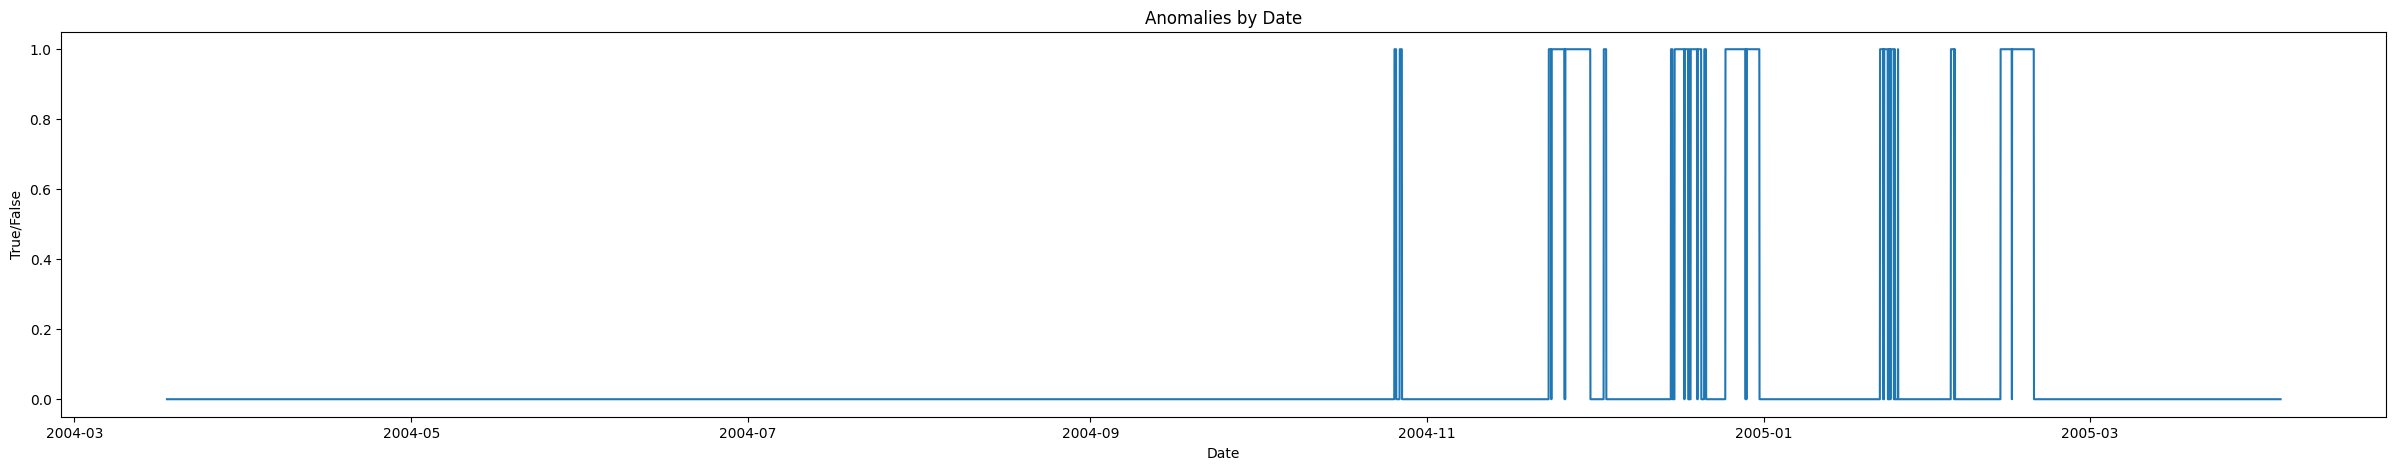

In [17]:
"""Run our sensor data through the AE and find anomalies"""
def locate_anomalies(model, data, upper, lower):
	reconstructions = model(data)
	loss = keras.losses.mean_squared_error(reconstructions, data)
	return (loss < lower) | (loss > upper)

anomalies = locate_anomalies(autoencoder, sequenced_testing, upper_threshold, lower_threshold)

plt.figure("Main", [30,5])
plt.title("Anomalies by Date")
plt.ylabel("True/False")
plt.xlabel("Date")
plt.plot(O3["Datetime"][168:], anomalies.numpy())
plt.show()

Pattern seems reasonable against the assumption that the sensor began to fail, got worse and worse until a tech came out to recalibrate.

In [18]:
"""Assuming anomalies mean sensor drift"""
drift = anomalies[-1]
print(f"The sensor is currently {'' if drift.numpy().item() else 'not '}drifting.")

The sensor is currently not drifting.


Just for fun... let's look for anomalies in the prediction data

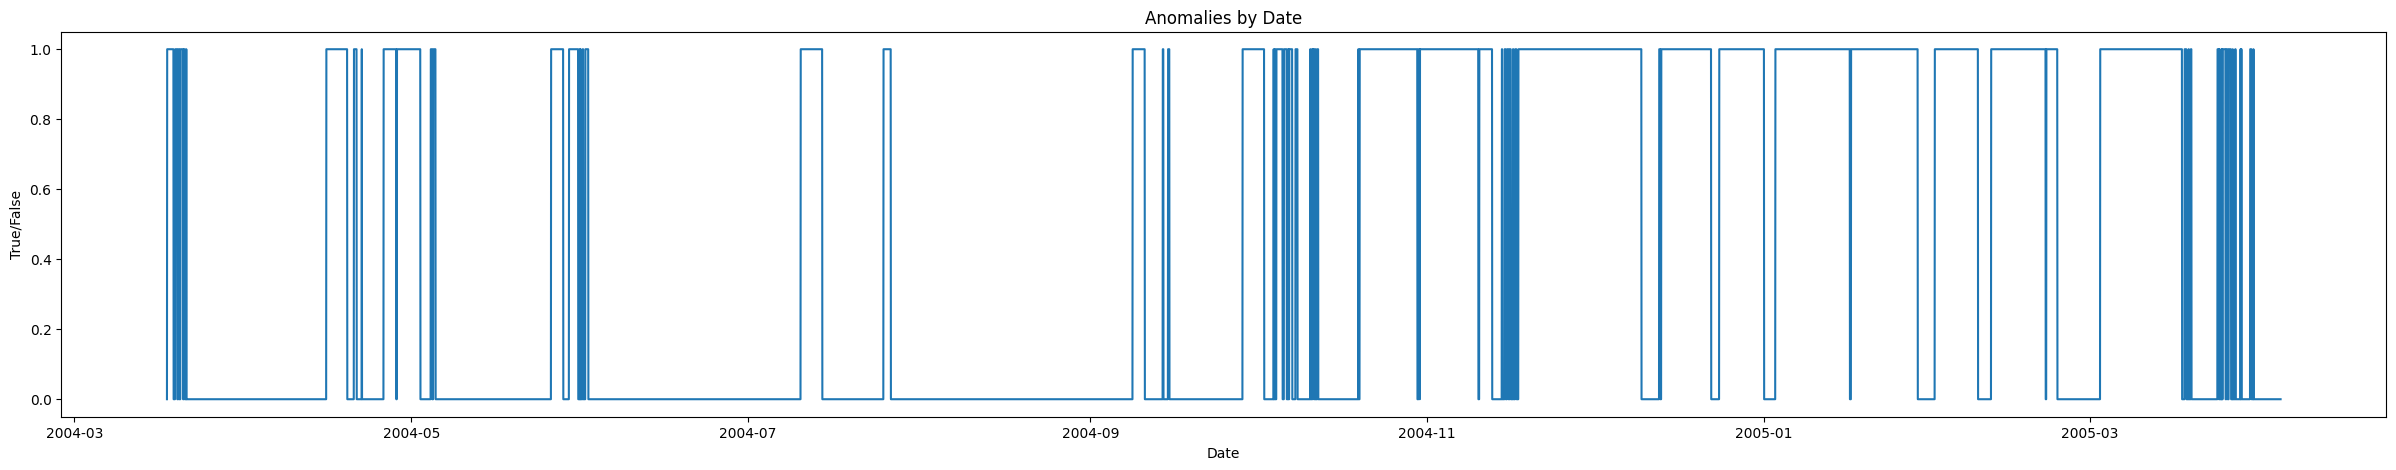

In [ ]:
"""Min-Max prediction data to match scale of C6H6 data"""
scaled_preds = predictions.copy()
minimum = C6H6["C6H6(GT)"].min()
maximum = C6H6["C6H6(GT)"].max()
scaled_preds["preds"] = (scaled_preds["preds"] - minimum) / (maximum - minimum)


"""Setup training data and testing data"""
training_data = C6H6["C6H6(GT)"]
testing_data = scaled_preds["preds"][24:]

min_val = min(training_data)
max_val = max(training_data)

training_data = (training_data - min_val) / (max_val - min_val)
testing_data = (testing_data - min_val) / (max_val - min_val)

training_data = training_data.astype(np.float32)
testing_data = testing_data.astype(np.float32)

seq_length = 7 * 24

sequenced_training = (
    np.array([training_data[i:i + seq_length] for i in range(len(training_data) - seq_length)], dtype=object)
    .astype(np.float32)
)
sequenced_testing = (
    np.array([testing_data[i:i + seq_length] for i in range(len(testing_data) - seq_length)], dtype=object)
    .astype(np.float32)
)

assert(sequenced_training.shape == (len(training_data) - seq_length, seq_length))
assert(sequenced_testing.shape == (len(testing_data) - seq_length, seq_length))

"""Run our sensor data through the AE and find anomalies"""
def locate_anomalies(model, data, upper, lower):
	reconstructions = model(data)
	loss = keras.losses.mean_squared_error(reconstructions, data)
	return (loss < lower) | (loss > upper)

anomalies = locate_anomalies(autoencoder, sequenced_testing, upper_threshold, lower_threshold)

plt.figure("Main", [30,5])
plt.title("Anomalies by Date")
plt.ylabel("True/False")
plt.xlabel("Date")
plt.plot(O3["Datetime"][168:], anomalies.numpy())
plt.show()

Lots and lots of anomalies in the prediction data, indicating that our predictions probably aren't the best.  It could also indicate a flaw in the anomaly detection mechanism.

In [ ]:
"""Push drift intel into predictions dataframe"""
drift = anomalies.numpy()
predictions["drift"] = pd.Series(drift, index=predictions.index[:len(drift)])
predictions

,Datetime,PT08.S5(O3),preds,drift
0,2004-03-10 18:00:00,1268.00000,NaN,False
1,2004-03-10 19:00:00,972.00000,NaN,False
2,2004-03-10 20:00:00,1074.00000,NaN,False
3,2004-03-10 21:00:00,1203.00000,NaN,False
4,2004-03-10 22:00:00,1110.00000,NaN,False
...,...,...,...,...
9376,2005-04-05 10:00:00,NaN,1992.59085,NaN
9377,2005-04-05 11:00:00,NaN,1998.19379,NaN
9378,2005-04-05 12:00:00,NaN,1919.33024,NaN
9379,2005-04-05 13:00:00,NaN,1708.71746,NaN


In [ ]:
"""Save predictions output to use in tableau"""
path_to_save = Path(Path.cwd().parents[1], "Data", "Benzene", "Tableau.csv")
predictions.to_csv(path_to_save, index=False)